# Similarity Learning with Covalent

In this workshop, we will:

- learn how to use `covalent` to **manage hybrid quantum-classical workflows** for similarity learning

- dispatch classical and classical-quantum (CQ) machine learning (ML) workflows that **recognize similar 2x2 pixel images**

- **compare the accuracy** of the two approaches and investigate the *learnt notion of similarity* in either model

Although we study a toy problem, the workflows introduced here could easily **represent real experiments** for existing quantum hardware.

This workshop can also serve as guide to *covalentify* your own workflows.

# Table of contents

1. [Getting Started with Covalent](#1-getting-started-with-covalent)

2. [Loading and Preparing Data](#2-loading-and-preparing-data)

3. [Dataset Visuals](#3-dataset-visuals)

4. [Classical Siamese Networks](#4-classical-siamese-networks)

5. [Quantum Similarity Networks](#5-quantum-similarity-networks)

6. [A Heterogeneous Workflow: Comparing Accuracies](#6-heterogeneous-comparing-accuracies)

7. [Investigating Learnt Notions of Similarity](#7-investigating-learnt-notions-of-similarity)

8. [Conclusions](#8-conclusions)

9. [References](#9-references)

# 1. Getting Started with Covalent <a id="1-getting-started-with-covalent"></a>

*If you haven't already done so, follow the steps below to set up an environment for this workshop:*

1. In the root directory of this repository, create a new `conda` environment by running

`> conda env create -f environment.yml`

2. Activate the environment

`> conda activate aps_march_covalent`

3. **Start covalent**

`> covalent start`

In your browser, navigate to <http://localhost:48008/>, where you should see the empty `covalent` GUI like below.

<img src="https://drive.google.com/uc?export=view&id=1g_Jo3P_ep38FGGjTNrT406JXxKc4ECWf" alt="empty_covalent_gui">

Congratulations! You have successfully launched `covalent`. **Keep this tab open in your browser**, we will need it for the rest of the workshop.

## Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import pennylane as qml

import covalent as ct

import os

# 2. Loading and Preparing Data <a id="2-loading-and-preparing-data"></a>

To do machine learning, we need data to learn from. Let's set up some data directory paths to be used later.

In [10]:
base_path = os.getcwd()
pixel_train = "".join([base_path, "/data/pixel_grid/training"])
pixel_test = "".join([base_path, "/data/pixel_grid/testing"])
faces_example = "".join([base_path, "/data/faces/training"])

The classical and quantum versions of the similarity networks used in this workshop interface with `Pytorch`.

<div align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" width=25%>
</div>

This means that the data needs to be pre-processed into the correct format. This introduces our first electron (i.e, task).

## 2.1. Electrons

An *electron* is just a python function decorated with `@ct.electron`. It is a granular task in our overall workflow.

In [11]:
@ct.electron
def file_to_pytorch_transform(file_root_dir, transform_dims):
    # Load the training dataset
    folder_dataset = datasets.ImageFolder(root=file_root_dir)

    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize(transform_dims),
                                         transforms.ToTensor()])

    return folder_dataset, transformation

For convenience, we want to produce data tuples $(x, \tilde{x}, y_{x, \tilde{x}})$, where

- $x$ and $\tilde{x}$ represent comparable images
- $y_{x, \tilde{x}}$ is the true label ($y_{x, \tilde{x}}$ = 1 for dissimilar objects and $y_{x, \tilde{x}}$ = 0 for similar objects).

We define the utility class `SimilarityModelDataset` (see ref [1]).

In [12]:
class SimilarityModelDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                # Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                # Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Add an electron that creates instances of the `SimilarityModelDataset` class.

In [13]:
@ct.electron
def similarity_learning_dataset(folder_dataset, transformation):
    dataset = SimilarityModelDataset(folder_dataset, transformation)
    return dataset

Add another electron that uses `torch.DataLoader` to iterate through the input data.

In [14]:
@ct.electron
def torch_dataloader(dataset, batch_size, shuffle=True):
    dataloader = DataLoader(dataset, shuffle=shuffle, batch_size=batch_size)
    return dataloader

## 2.2. Lattice

Let's define our first workflow! We'll use it to load all of the datasets used in this Workshop.

The `@ct.lattice` decorator is used to create a workflow from Python functions that call *electrons*.

In [15]:
@ct.lattice
def data_preprocessing_workflow(data_paths, batch_sizes, transforms_vector):
    dataloaders = []
    for data_path, batch_size, dims in zip(data_paths, batch_sizes, transforms_vector):

        # Call all of the data pre-processing electrons
        folder_dataset, transformation = file_to_pytorch_transform(file_root_dir=data_path,
                                                                   transform_dims=dims)

        dataset = similarity_learning_dataset(folder_dataset, transformation)

        dataloader = torch_dataloader(dataset, batch_size)

        dataloaders.append(dataloader)

    return dataloaders


# dispatch workflow
dispatch_id = ct.dispatch(data_preprocessing_workflow)(data_paths=[pixel_train, pixel_test, faces_example],
                                                       batch_sizes=[8, 1, 1],
                                                       transforms_vector=[(2, 2), (2, 2), (100, 100)])
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
dataloaders = ct_results.result

This will complete fairly instantly. On the GUI, we will be able to inspect the completed workflow.

<img src="https://drive.google.com/uc?id=1TfORyqSxIeLMRJqc2JVDjY-V4DQ7Hnb4" alt="first_lattice_dispatch_list">

Click on the dispatch ID to see the workflow *transport graph*.

<img src="https://drive.google.com/uc?id=1lXMVaWXjF8yuFbgNxd2mYtR7D_VKocdq" alt="data_preprocessing_graph">

Take some time now to play around with the GUI.

Notice **three separate** graphs (i.e, groups of disjoint electrons). Covalent has recognized them as **independent computations**. By default, these are run in parallel using `dask` (i.e. using Covalent's dask *executor*).

<div align="center">
<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg" width=25%>
</div>

With little more than the addition of a decorator, we have **auto-parallelized our workflow**!

In [16]:
print("Workflow took %.5f seconds to complete" % ((ct_results.end_time - ct_results.start_time).total_seconds()))

Workflow took 1.33193 seconds to complete


Also note that, With `covalent`, intermediate results **are not lost**. All electron outputs are serialized and can be retrieved using 

`res = ct_results.get_all_node_outputs()`

 - outputs can be deserialized to the original result object using the `get_deserialized()` method.
 - outputs can be copied to clipboard directory from the GUI

See the RTD page <https://covalent.readthedocs.io/en/stable/> for more useful features.

# 3. Dataset Visuals <a name="3-dataset-visuals"></a>

Let's open some of the datasets from the workflow we just ran, starting with the testing dataset of 2x2 pixel grids

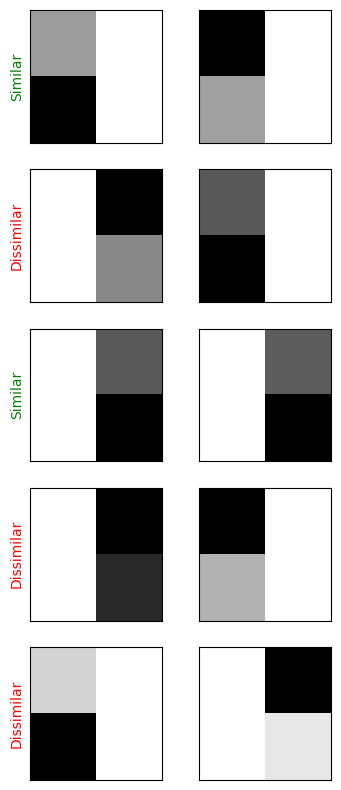

In [17]:
# Display a couple of items from the training dataset
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=[4, 10])

iterarable_pixels = iter(dataloaders[1])
for i in range(5):
    # Pixels first
    x1_pixel, x2_pixel, label_pixel = next(iterarable_pixels)
    axs[i, 0].imshow(x1_pixel[0, 0, :, :], cmap="Greys")
    axs[i, 1].imshow(x2_pixel[0, 0, :, :], cmap="Greys")
    axs[i, 0].set_xticks([]); axs[i, 1].set_xticks([])
    axs[i, 0].set_yticks([]); axs[i, 1].set_yticks([])
    # Display label
    if label_pixel == 1:
        axs[i, 0].set_ylabel('Dissimilar', color="red")
    else:
        axs[i, 0].set_ylabel('Similar', color="green")

- Images labelled as **similar** ($y_{x \tilde{x}} = 0$) are those sharing a side with zeroed-out pixels. 

- Images labelled **dissimilar** ($y_{x \tilde{x}} = 1$) are those having zeroed-out pixels on *opposite* sides.

What does this all mean in the context of a more realistic dataset? Let's take a look at some faces...

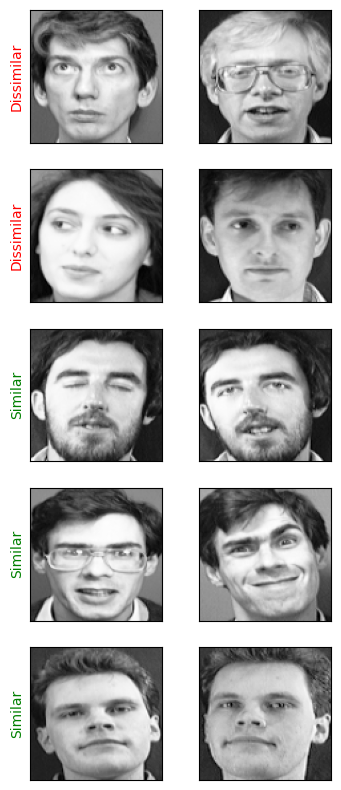

In [18]:
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=[4, 10])
iterable_faces = iter(dataloaders[2])
for i in range(5):
    # Faces second
    x1_face, x2_face, label_face = next(iterable_faces)
    axs[i, 0].imshow(x1_face[0, 0, :, :], cmap="Greys_r")
    axs[i, 1].imshow(x2_face[0, 0, :, :], cmap="Greys_r")
    axs[i, 0].set_xticks([]); axs[i, 1].set_xticks([])
    axs[i, 0].set_yticks([]); axs[i, 1].set_yticks([])

    # Display label
    if label_face == 1:
        axs[i, 0].set_ylabel('Dissimilar', color="red")
    else:
        axs[i, 0].set_ylabel('Similar', color="green")

- images of the same person are **similar** ($y_{x \tilde{x}} = 0$)
- images of different persons are **dissimilar** ($y_{x \tilde{x}} = 1$)

Algorithm capable of performing such distinctions is useful in areas like facial recognition.

# 4. Classical Siamese Networks <a name="4-classical-siamese-networks"></a>

A classical Siamese network tackles the similarity learning task by jointly training twin (think Siamese...) neural networks using a **contrastive loss**. A typical layout of a Siamese network is shown below.

![A schematic of a classical Siamese network.](./images/siamese_network.png)

Source: <https://www.youtube.com/watch?v=4S-XDefSjTM>

While such networks usually involve dimension reduction of the image to create a low-dimensional latent space (via something like `torch.nn.MaxPool2d`), we are already working with 2x2 pixel grayscale images so we can skip this part. 

Lets create a `PyTorch` network involving *convolutional* and *linear* layers (see ref [1]).

## 4.1. Model

In [19]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True),
            # Maxpooling here if image was larger dimensions...
            
            nn.Conv2d(2, 4, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True),
            # Maxpooling here if image was larger dimensions...

            nn.Conv2d(4, 8, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True)
        )

        # Setting up the Sequential of Fully Connected linear Layers
        self.fc1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the raw (pre-sigmoidal) similarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # Here we pass in both images and obtain both vectors
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

## 4.2. Loss

We now have a network which outputs a latent vector upon insertion of an image.

To quantify the comparison of two different images, we use a *contrastive loss* between latent vectors (see ref [1]).

In [20]:
class ClassicalContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ClassicalContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidean distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        loss_contrastive = torch.mean(
            (1-label) * torch.pow(euclidean_distance, 2)
            + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        loss_contrastive = 2*(torch.sigmoid(loss_contrastive) - 0.5) # Mean square loss is positive. Rescale in 0 1
        return loss_contrastive

We'll use an *electron* to create a `ClassicalContrastiveLoss` instance:

In [21]:
@ct.electron
def classical_contrastive_loss(margin=2):
    contrastive_loss = ClassicalContrastiveLoss(margin)
    return contrastive_loss

## 4.3. Training

Next, an electron to train the network:

In [22]:
@ct.electron
def train_classical_siamese_network(train_dataloader, torch_optim, lr,
                                    loss_function, epochs, print_intermediate=False):
    
    # Create network instance here
    network = SiameseNetwork()
    optimizer = torch_optim(network.parameters(), lr)
    loss_history = [] 

    # Outer training loop
    for epoch in range(epochs):

        # Iterate over batches
        for i, (img1, img2, label) in enumerate(train_dataloader, 0):

            # Images and labels
            img1, img2, label = img1.cpu(), img2.cpu(), label.cpu()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = network.cpu()(img1, img2)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = loss_function(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Loss appended at the end of each batch
            loss_history.append(loss_contrastive.item())

            # Every 10 epochs print out the loss
        if print_intermediate:
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")

    return network, loss_history

an electron to get the simlarity between unseen images and return a prediction.

In [23]:
@ct.electron
def get_similarity(x1, x2, trained_net):
    output1, output2 = trained_net(x1.cpu(), x2.cpu())
    euclidean_distance = F.pairwise_distance(output1, output2)
    scaled_dist = 2*(torch.sigmoid(euclidean_distance) - 0.5)
    prediction = torch.round(scaled_dist)
    return scaled_dist, prediction

## 4.4. Testing

Finally, an electron to run testing:

In [24]:
@ct.electron
def get_testing_results(dataloader_test, trained_net, num_dat=None):
    results = []
    iterable = iter(dataloader_test)
    if num_dat is None:
        num_dat = len(dataloader_test.dataset)
    for i in range(num_dat):
        x1, x2, label = next(iterable)
        scaled_dist, prediction = get_similarity(x1, x2, trained_net)
        results.append([label.item(), prediction.item(), scaled_dist.item()])
    return results

## 4.5. Workflow

We can now define a simple workflow:
- load the training and testing data and perform preprocessing
- train the network with contrastive loss
- compare predictions against the ground truth (for 5 elements of the testing dataset)

In [25]:
@ct.lattice
def classical_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr, print_intermediate, test_num_dat):

    # Grab datasets using the sublattice from before
    dataloader_train, dataloader_test = data_preprocessing_workflow(data_paths=[train_path, test_path],
                                                                    batch_sizes=[8, 1],
                                                                    transforms_vector=[(2, 2), (2, 2)])

    # Siamese network initialization
    contrastive_loss = classical_contrastive_loss()

    # Train the network
    trained_net, loss_history = train_classical_siamese_network(torch_optim=pytorch_optimizer,
                                                               train_dataloader=dataloader_train,
                                                               loss_function=contrastive_loss,
                                                               epochs=epochs,
                                                               print_intermediate=print_intermediate, lr=lr)
    
    # Perform predictions on testing data with the trained network
    results = get_testing_results(dataloader_test, trained_net, num_dat=test_num_dat)
    
    return results, loss_history, trained_net


# dispatch the workflow
dispatch_id = ct.dispatch(classical_workflow)(train_path=pixel_train,
                                              test_path=pixel_test,
                                              train_batch=8,
                                              pytorch_optimizer=torch.optim.Adam,
                                              epochs=5,
                                              lr=0.005,
                                              print_intermediate=False,
                                              test_num_dat=5)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

Once completed, the GUI should display the below

<img src="https://drive.google.com/uc?id=1NghkYSh1epUc0_b2xHInnYP8TJr-N_Su" alt="classical_training_graph">

In [26]:
results, loss_history, trained_net = ct_results.result

## 4.6. Post-processing

Let's check out the loss history (after an admittedly small number of epochs)

Text(0, 0.5, 'Classical loss')

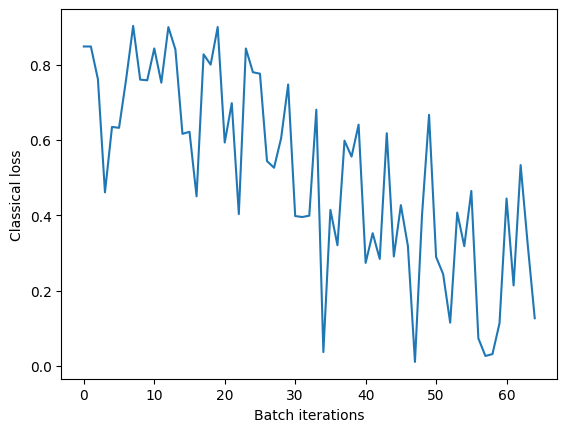

In [27]:
plt.plot(loss_history)
plt.xlabel('Batch iterations')
plt.ylabel('Classical loss')

and predictions

In [28]:
for i, res in enumerate(results):
    # first element ground truth label, second element predicted label.
    if res[0] == res[1]:
        print('Got test %d correct. Predicted label = %d, truth label = %d' % (i, res[1], res[0]))

Got test 0 correct. Predicted label = 0, truth label = 0
Got test 1 correct. Predicted label = 0, truth label = 0
Got test 2 correct. Predicted label = 1, truth label = 1
Got test 3 correct. Predicted label = 1, truth label = 1
Got test 4 correct. Predicted label = 0, truth label = 0


# 5. Quantum Similarity Networks <a name="5-quantum-similarity-networks"></a>

There exist ways to learn similarity using variational quantum circuits in a way that's analogous to classical neural nets (see Radha and Jao, ref [2]).

<div align="center">
<img src="https://drive.google.com/uc?id=1uKdcU3BYSgcIF1cm8Lh4fHmAbkfmUSW_" width="75%" alt="quantum_net">
</div>

Specifically, we'll use a 5 qubit ($n=5$) system and with $m=2$ measured qubits. We proceed with $V_{\eta}(\tilde{x}) = U^{\dagger}_{\eta}(\tilde{x})$.

Throughout this section, we use the `Pennylane` software package for building and optimizing quantum circuits (with a `Pytorch` interface).
<div align="center">
<img src="https://pennylane.ai/img/pennylane_logo.svg" width="50%" alt="Pennylane logo">
</div>

## 5.1. Pennylane Device

We begin by specifying the backend quantum device:


In [29]:
dev = qml.device('lightning.qubit', wires=5)
# dev = qml.device('default.qubit', wires=5)

This is a local quantum circuit simulator for the purposes of this workshop. This can of course be different for a real heterogeneous workflow as we will allude to later on.

### Debugging (if necessary)

> If `'lightning.qubit'` does not work on your machine, please replace it with `'default.qubit'` in the above cell.

## 5.2. Quantum Circuit Definition

In [30]:
@ct.electron
@qml.qnode(dev, interface='torch')
def similarity_circuit(x1, x2, alpha1, alpha2, wires, ansatz=qml.QAOAEmbedding, measure_bits=2):
    # Basically a kernel
    ansatz(features=x1, weights=alpha1, wires=wires)
    qml.adjoint(ansatz)(features=x2, weights=alpha2, wires=wires)
    # Measure only first measure_bits qubits.
    return [qml.expval(qml.PauliZ(i)) for i in range(measure_bits)]

Notice that it's totally fine to doubly decorate a function. Notice, also, that the form of $U$ is set by default to `qml.QAOAEmbedding`:

<div align="center">
<img src="https://drive.google.com/uc?id=1a_Ejp0RM0-3qKIqfiQGH_aq8S5CWn_b2" alt="qaoa_embedding" width=75%>
</div>

More information on this embedding can be found at <https://docs.pennylane.ai/en/stable/code/api/pennylane.QAOAEmbedding.html>

## 5.3. Quantum Cost Function

- The QAOA circuits are embedded with all 4 pixels from the two 2x2 pixel grids.
- The 'distance' between *one pair of images* is calculated using the expected value of the *Pauli-Z* operator for both `measure_bits`.
- This distance is then inserted into the same form of **contrastive loss** as for the classical Siamese network.
- We take the average distance over a batch size and rescaled into 0-1.

In [31]:
@ct.electron
def quantum_cost(batch, alpha1, alpha2, wires, similarity_circuit, measure_bits=2):
    x1_batch, x2_batch, label_batch = batch
    batch_size = len(x1_batch)
    all_costs = torch.zeros(batch_size)
    for i in range(batch_size):

        x1 = torch.flatten(x1_batch[i])  # embedding requires flat tensor
        x2 = torch.flatten(x2_batch[i])
        label = label_batch[i]

        # get expectation values
        expectation_values = similarity_circuit(
            x1, x2, alpha1, alpha2, wires, ansatz=qml.QAOAEmbedding, measure_bits=measure_bits
        )

        # rescale into 0-1
        dist = (torch.mean(expectation_values) + 1) / 2

        # compute contrastive loss
        loss_contrastive = (
            (1-label) * torch.pow(dist, 2)
            + (label) * torch.pow(torch.clamp(0.9 - dist, min=0.0), 2)
        )

        all_costs[i] = loss_contrastive

    # return average loss over batch iterations
    return torch.mean(all_costs)

## 5.4. Training (Quantum)

We make an electron to specify random initial rotation angles for QAOA embedding:

In [32]:
@ct.electron
def get_random_init_params(n_qubits, layers, ansatz=qml.QAOAEmbedding):
    alpha1 = torch.tensor(np.random.uniform(size=ansatz.shape(layers, n_qubits)), requires_grad=True)
    alpha2 = torch.tensor(np.random.uniform(size=ansatz.shape(layers, n_qubits)), requires_grad=True)
    return alpha1, alpha2

Now, using the `pennylane`-`PyTorch` interface, we implement a training electron.

Note that the classical and quantum networks can be trained with the **same choice of optimizer!**

In [33]:
@ct.electron
def train_quantum_net(lr, init_params, dataloader_train, batch_cost_func, similarity_circuit,
                      measure_bits, epochs, pytorch_optimizer, print_intermediate=False):

    opt = pytorch_optimizer(init_params, lr=lr)
    dataiter = iter(dataloader_train)
    alpha1, alpha2 = init_params

    def closure():
        opt.zero_grad()
        loss = batch_cost_func(next(dataiter), alpha1, alpha2, 
                               similarity_circuit=similarity_circuit,
                               wires=dev.wires, measure_bits=measure_bits)
        loss.backward()
        return loss
    
    loss_history = [] 
    for epoch in range(epochs):
        dataiter = iter(dataloader_train)
        for i in range(len(dataloader_train)):
            loss = opt.step(closure)
            loss_history.append(loss.item()) 
        if epoch % 10 == 0 and print_intermediate:
            print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
    return loss_history, opt

Two more electrons:

- to calculate the distance function (without the full contrastive loss)
- to make a prediction based upon the distance

In [34]:
@ct.electron
def get_quantum_prob(x1, x2, label, alpha1, alpha2, wires, similarity_circuit, ansatz=qml.QAOAEmbedding, measure_bits=2):
    x1 = torch.flatten(x1) # embedding requires flat tensor
    x2 = torch.flatten(x2)

    expectation_values = similarity_circuit(
        x1, x2, alpha1, alpha2, wires, ansatz=ansatz, measure_bits=measure_bits
    )

    # rescale into 0-1
    dist = (torch.mean(expectation_values) + 1) / 2
    return dist


@ct.electron
def quantum_predict(quantum_prob):
    # prediction (0 or 1) from rounded probability
    return torch.round(quantum_prob)

## 5.5. Testing (Quantum)

The above two electrons are now used within an electron to get all the testing results

In [35]:
@ct.electron
def get_test_results_quantum(dataloader_test, opt_params, prob_func, predict_func, wires, measure_bits, num_dat=None):
    # pass a dataloader with batch size of 1 to cycle through testing
    alpha1, alpha2 = opt_params
    iterable = iter(dataloader_test)
    results = []
    if num_dat is None:
        num_dat = len(dataloader_test.dataset)
    for i in range(num_dat):
        x1, x2, label = next(iterable)
        x1 = torch.flatten(x1) # embedding requires flat tensor
        x2 = torch.flatten(x2)

        prob = prob_func(x1, x2, label, alpha1, alpha2, wires, similarity_circuit, ansatz=qml.QAOAEmbedding, measure_bits=2)
        prediction = predict_func(prob)
        results.append([label.item(), prediction.item(), prob.item()])
    return results

## 5.6. Workflow (Quantum)

We can now create the quantum workflow which, as you will notice, shares many similarities with the classical one!

*Note, the cell below may take a minute or two.*

In [36]:
@ct.lattice
def quantum_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr, print_intermediate, test_num_dat):

    # Grab datasets using the sublattice from before
    dataloader_train, dataloader_test = data_preprocessing_workflow(data_paths=[train_path, test_path],
                                                                    batch_sizes=[8, 1],
                                                                    transforms_vector=[(2, 2), (2, 2)])

    # Get initial parameters for quantum net. We hardcode the 5 qubit 2 layer QAOA ansatz.
    alpha1, alpha2 = get_random_init_params(5, 2)

    # pass relevant electron functions to training routine. Measure_bits=2 is also hardcoded
    loss_history, opt = train_quantum_net(lr=lr, init_params=[alpha1, alpha2],
                                          dataloader_train=dataloader_train,
                                          batch_cost_func=quantum_cost, # is an electron function
                                          similarity_circuit=similarity_circuit, # is an electron function
                                          measure_bits=2, epochs=epochs,
                                          pytorch_optimizer=pytorch_optimizer,
                                          print_intermediate=False)

    results = get_test_results_quantum(dataloader_test, opt.param_groups[0]['params'],
                                       prob_func=get_quantum_prob, 
                                       predict_func=quantum_predict,
                                       wires=dev.wires,
                                       measure_bits=2, num_dat=test_num_dat)

    return results, loss_history, opt


# dispatch quantum workflow
dispatch_id = ct.dispatch(quantum_workflow)(train_path=pixel_train,
                                            test_path=pixel_test,
                                            train_batch=8,
                                            pytorch_optimizer=torch.optim.Adam,
                                            epochs=5,
                                            lr=0.05,
                                            print_intermediate=False,
                                            test_num_dat=5)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

One again, we can examine the workflow graph on the GUI. It should appear as below

<img src="https://drive.google.com/uc?id=1wvDmXvR9VLhXn_IwBhcPWKDGsk2pH1Vn" alt="quantum_training_graph">

Now we'll pull the results back from the `covalent` server

In [37]:
results, loss_history, trained_opt = ct_results.result

## 5.7. Post-Processing (Quantum)

Lets examine the loss history and predictions, as before.

Text(0, 0.5, 'Quantum loss')

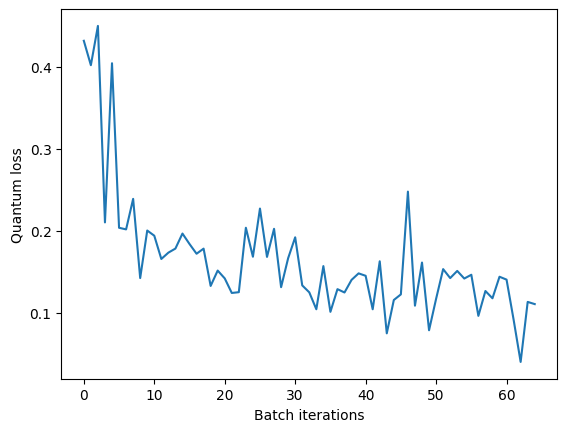

In [38]:
plt.plot(loss_history)
plt.xlabel("Batch iterations")
plt.ylabel("Quantum loss")

In [39]:
for i, res in enumerate(results):
    # first element ground truth label, second element predicted label.
    if res[0] == res[1]:
        print('Got test %d correct. Predicted label = %d, truth label = %d' % (i, res[1], res[0]))

Got test 0 correct. Predicted label = 1, truth label = 1
Got test 1 correct. Predicted label = 0, truth label = 0
Got test 3 correct. Predicted label = 0, truth label = 0
Got test 4 correct. Predicted label = 0, truth label = 0


# 6. A Heterogeneous Workflow: Comparing Accuracies <a id="6-heterogeneous-comparing-accuracies"></a>

Here, we'll use `covalent` to run workflow that compares our **classical vs. quantum similarity** learning models.

In [40]:
@ct.electron
def get_accuracy_score(results_tuples):
    # Process the (label, prob, prediction) tuple and return an accuracy percentage
    correct_counter = 0
    for result in results_tuples:
        if result[0] == result[1]: # Label matches prediction
            correct_counter += 1
        else:
            continue
    return 100*correct_counter/len(results_tuples)

## 6.1. Workflow (Classical and Quantum)

We can actually re-use the classical and quantum workflows from before (as *sublattices*) to define a `quantum_classical_workflow`.

In [41]:
@ct.lattice
def quantum_classical_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr_c, lr_q, print_intermediate):

    # Run the classical sublattice
    results_classical, loss_history_classical, trained_net_c = \
         classical_workflow(train_path=pixel_train,
                            test_path=pixel_test,
                            train_batch=train_batch,
                            pytorch_optimizer=pytorch_optimizer,
                            epochs=epochs,
                            lr=lr_c,
                            print_intermediate=print_intermediate,
                            test_num_dat=None)

    # Run the quantum sublattice
    results_quantum, loss_history_quantum, trained_opt_q = \
         quantum_workflow(train_path=train_path,
                          test_path=test_path,
                          train_batch=train_batch,
                          pytorch_optimizer=pytorch_optimizer,
                          epochs=epochs,
                          lr=lr_q,
                          print_intermediate=print_intermediate,
                          test_num_dat=None)

    # Calculate the accuracy scores
    acc_classical = get_accuracy_score(results_classical)
    acc_quantum = get_accuracy_score(results_quantum)
    return (acc_classical, acc_quantum, trained_net_c, trained_opt_q,
            loss_history_classical, loss_history_quantum, results_quantum, results_classical)

To make this more realistic, we increase the number of training epochs from 5 to 20 and perform testing on the entire testing dataset.

*This cell may take a few minutes to complete.*

In [42]:
dispatch_id = ct.dispatch(quantum_classical_workflow)(train_path=pixel_train,
                                                      test_path=pixel_test,
                                                      train_batch=8,
                                                      pytorch_optimizer=torch.optim.Adam,
                                                      epochs=20,
                                                      lr_q=0.05,
                                                      lr_c=0.0005,
                                                      print_intermediate=False)

ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

print("Quantum-classical workflow took %.5f seconds to complete" % ((ct_results.end_time - ct_results.start_time).total_seconds()))

Quantum-classical workflow took 452.04690 seconds to complete


If you go to the GUI, you should be able to see the flow progressing through the transport graph in real-time. The completed graph should look like the below:

<img src="https://drive.google.com/uc?id=1Nlffe2BtDhUCxVU_zQftOzRc-g2rh7Hr" alt="quantum_classical_training_graph">

In [43]:
acc_classical, acc_quantum, trained_net_c, trained_opt_q, loss_history_classical,\
     loss_history_quantum, results_quantum, results_classical = \
     ct_results.result

## 6.2. Post-Processing (Classical and Quantum)

Let's now examine the accuracy scores from each network

In [44]:
print("Accuracy score for classical Siamese network:", acc_classical, "%")
print("Accuracy score for quantum similarity network:", acc_quantum, "%")

Accuracy score for classical Siamese network: 98.0 %
Accuracy score for quantum similarity network: 91.0 %


These are interesting insights, however, (and convince yourself of this if you have the time), these results will vary upon different random initializations of network parameters and the effectiveness of the subsequent training.

To make any real conclusions about the different methods *on this dataset*, we would have to run very many training instances using different random parameter initializations. This is beyond the scope of this workshop.

Let's now look at the loss functions beside one another

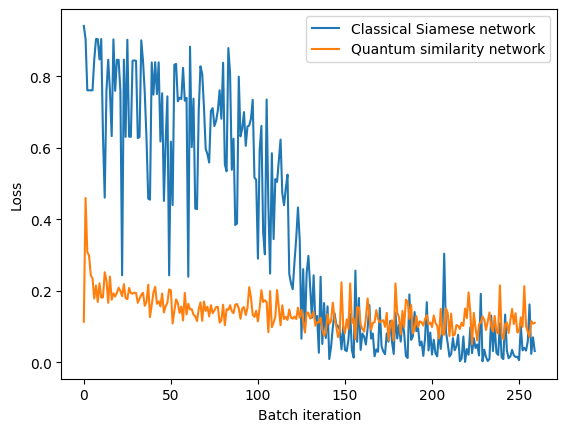

In [45]:
plt.plot(loss_history_classical, label="Classical Siamese network")
plt.plot(loss_history_quantum, label="Quantum similarity network")
plt.xlabel('Batch iteration')
plt.ylabel('Loss')
plt.legend()

Do you see any distinct difference in the training behavior?

### Why use Covalent?

Apart from default auto-parallelization and other organizational benefits mentioned earlier, `covalent` adds the possibility of making this workflow **truly heterogeneous**.

### How to Scale?

Electrons easily can be sent to remote classical or quantum compute resources. (You would need to set up billing and credentials with cloud compute providers etc.).

This is often as easy as passing the the desired `executor` to an electron:

```python
executor = ct.executor.EC2Executor(
    username="ubuntu",
    ssh_key_file="/home/user/.ssh/ssh_key.pem",
    key_name="ssh_key"
    instance_type="t2.micro",
    volume_size="8GiB",
    ami="amzn-ami-hvm-*-x86_64-gp2",
    vpc="vpc-07bdd9ca40c4c50a7",
    subnet="subnet-0a0a7f2a7532383c3",
    profile="custom_user_profile",
    credentials_file="~/.aws/credentials"
)

@ct.electron(executor=executor)
def my_custom_task(x, y):
    return x + y
```

We can also access quantum resources:

```python
@ct.electron(executor="braket")
def my_hybrid_task(num_qubits: int, shots: int):
    import pennylane as qml

    # These are passed to the Hybrid Jobs container at runtime
    device_arn = os.environ["AMZN_BRAKET_DEVICE_ARN"]
    s3_bucket = os.environ["AMZN_BRAKET_OUT_S3_BUCKET"]
    s3_task_dir = os.environ["AMZN_BRAKET_TASK_RESULTS_S3_URI"].split(s3_bucket)[1]

    device = qml.device(
        "braket.aws.qubit",
        device_arn=device_arn,
        s3_destination_folder=(s3_bucket, s3_task_dir),
        wires=num_qubits,
        shots=shots,
        parallel=True,
        max_parallel=4
    )

    @qml.qnode(device)
    def circuit():
        # Define the circuit here
        ...
```

For more information, check out the plugins page on RTD <https://covalent.readthedocs.io/en/stable/plugins.html>

# 7. Investigating Learnt Notions of Similarity <a id="7-investigating-learnt-notions-of-similarity"></a>

- What about all of the *in-between* pixel grids? 
- What about grids which are equally left and right sided? 

Let us now investigate these with a simple test.

In [46]:
@ct.electron
def generate_left_right_transition(num_images):
    image_pairs = []
    
    left_image = torch.tensor([[[1.0, 0],
                               [1.0, 0]]], requires_grad=False, dtype=torch.float32)
    
    for intensity in torch.tensor(np.linspace(0, 1, num_images), requires_grad=False, dtype=torch.float32):
        image = torch.tensor([[[1.0-intensity, intensity],
                              [1.0-intensity, intensity]]], requires_grad=False, dtype=torch.float32)
        image_pairs.append([left_image, image, 2]) # 2 is the label; different on purpose to previous
    
    return image_pairs

The above electron generates pairs of pixel grids. The first element of the pair is *always* fully left-sided while the second element of the pair slowly becomes more and more right sided.

We display the *second* element from 20 pairs below

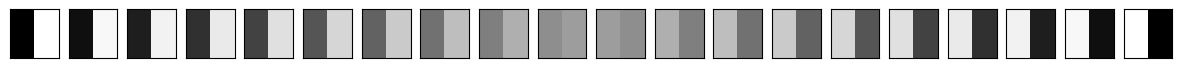

In [47]:
image_pairs = generate_left_right_transition(20)
fig, axs = plt.subplots(1, 20, figsize=[15, 2])
for i, image_pair in enumerate(image_pairs):
    axs[i].imshow(image_pair[1][0], vmin=0, vmax=1, cmap="Greys")
    axs[i].set_yticks([]); axs[i].set_xticks([])

## 7.1. Workflow (Investigation)

Making use of the trained models from before, we now set up another heterogeneous workflow to score each of the pairs.

In [48]:
@ct.lattice
def similarity_experiment(num_images, trained_net_c, trained_opt_q):

    image_pairs = generate_left_right_transition(num_images)

    dataloader_test = torch_dataloader(image_pairs, shuffle=False, batch_size=1)

    results_c = get_testing_results(dataloader_test, trained_net_c)

    results_q = get_test_results_quantum(
        dataloader_test, trained_opt_q.param_groups[0]['params'],
        prob_func=get_quantum_prob, 
        predict_func=quantum_predict,
        wires=dev.wires,
        measure_bits=2
    )

    return results_c, results_q


# dispatch the workflow
dispatch_id = ct.dispatch(similarity_experiment)(num_images=20, trained_net_c=trained_net_c, trained_opt_q=trained_opt_q)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
results_c, results_q = ct_results.result


This should produce a comparatively simpler workflow to the previous one in the GUI

<img src="https://drive.google.com/uc?id=1RzOPKikfOt8GqApgKzrQvKocedm4Xug7" alt="similarity_notion_compare_graph">

## 7.2. Comparing Similarity Scores

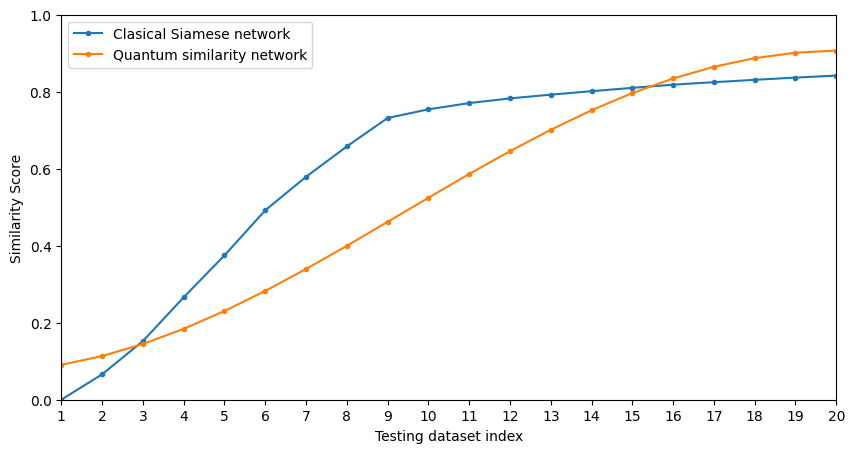

In [49]:
plt.figure(figsize=[10, 5])
plt.plot(range(1, 21), [results_c[i][2] for i in range(len(results_c))], '.-', label="Clasical Siamese network")
plt.plot(range(1, 21), [results_q[i][2] for i in range(len(results_q))], ".-", label="Quantum similarity network")
plt.ylim(0, 1); plt.xlim(1, 20)
plt.xticks(range(1, 21))
plt.ylabel('Similarity Score')
plt.xlabel('Testing dataset index')
plt.legend()

The above similarity score curves will very likely look different for the quantum and classical cases (they do at least in the pre-executed notebook).

As this is a current research topic, we leave it to you to explain/rationalize these differences! Have a discussion with your neighbor perhaps?

# 8. Conclusions <a id="8-conclusions"></a>

Well done! Let's take a moment to summarize what we have learned.

1. By functionalizing our code and using two decorators (`@ct.electron` and `@ct.lattice`), we can use `covalent` to **manage heterogeneous workflows in machine learning and beyond.**

2. Covalent gives us out-of-the-box `dask` parallelization, a clean GUI, and several other useful features (like autosaving of intermediate results).

3. With little added effort, we can send different electrons to different classical or quantum resources using **Covalent's plugin library** <https://covalent.readthedocs.io/en/stable/plugins.html>

4. All together, Covalent allows for efficient and organized structuring of ML/QML projects, as demonstrated by our similarity learning experiments.

**How you could use covalent in your research?**

# 9. References <a id="9-references"></a>

[1] Siamese Network in Pytorch with application to face similarity, <https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/>

[2] Radha, S.K. and Jao, C., 2022. Generalized quantum similarity learning. arXiv preprint <https://arxiv.org/abs/2201.02310>